In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning import *

/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Setup
---

## Load data


In [2]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

* ## Training set

In [3]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


* ## Validation set 

In [4]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


* ## Test set 

In [5]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00']


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


In [6]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,0.4433,0.4378
2024-06-03 01:20:00,0.4458,0.4400
2024-06-03 01:25:00,0.4464,0.4407
2024-06-03 01:30:00,0.4474,0.4424
2024-06-03 01:35:00,0.4468,0.4416
...,...,...
2024-06-29 23:20:00,0.3312,0.3263
2024-06-29 23:35:00,0.3311,0.3261
2024-06-29 23:40:00,0.3307,0.3259


In [7]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,0.4433,0.4378
2024-06-03 01:20:00,0.4458,0.4400
2024-06-03 01:25:00,0.4464,0.4407
2024-06-03 01:30:00,0.4474,0.4424
2024-06-03 01:35:00,0.4468,0.4416
...,...,...
2024-06-29 23:20:00,0.3312,0.3263
2024-06-29 23:35:00,0.3311,0.3261
2024-06-29 23:40:00,0.3307,0.3259


# Train agent
---

In [8]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(0.5, 2.5), (1.0, 3.0), (1.5, 4.0), (2.0, 4.5), (2.5, 5.0), (3.0, 5.5)]
# Training parameters
F, T = 100, 50 #Formation is the last 16 hours and trading is the next 8 hours
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,win_rate_history,loss_rate_history,forced_exit_rate_history,no_trade_rate_history = train_dqn(zscore_series_train, 
                                                                                                                                                                                    prices_train, 
                                                                                                                                                                                    beta_series_train,
                                                                                                                                                                                    zscore_series_val,
                                                                                                                                                                                    prices_val,
                                                                                                                                                                                    beta_series_val,
                                                                                                                                                                                    initial_capital,
                                                                                                                                                                                    tx_cost,
                                                                                                                                                                                    entry_stop_pairs, 
                                                                                                                                                                                    F, 
                                                                                                                                                                                    T, 
                                                                                                                                                                                    num_epochs=1000,
                                                                                                                                                                                    batch_size=32,
                                                                                                                                                                                    gamma = 0.99,
                                                                                                                                                                                    lr = 0.001,
                                                                                                                                                                                    epsilon_start = 1,
                                                                                                                                                                                    epsilon_end = 0.01,
                                                                                                                                                                                    epsilon_decay = 0.995,
                                                                                                                                                                                    replay_capacity = 1000,
                                                                                                                                                                                    target_update_freq = 10,
                                                                                                                                                                                    hidden_dim = 64,                                           
                                                                                                                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Epoch 01 | AvgReward: 77.44 | Epsilon: 0.995
Epoch 02 | AvgReward: 55.64 | Epsilon: 0.990
Epoch 03 | AvgReward: 43.61 | Epsilon: 0.985
Epoch 04 | AvgReward: 52.63 | Epsilon: 0.980
Epoch 05 | AvgReward: 57.89 | Epsilon: 0.975
Epoch 06 | AvgReward: 54.14 | Epsilon: 0.970
Epoch 07 | AvgReward: 52.63 | Epsilon: 0.966
Epoch 08 | AvgReward: 33.83 | Epsilon: 0.961
Epoch 09 | AvgReward: 33.08 | Epsilon: 0.956
Epoch 10 | AvgReward: 67.67 | Epsilon: 0.951
Epoch 11 | AvgReward: 69.17 | Epsilon: 0.946
Epoch 12 | AvgReward: 66.17 | Epsilon: 0.942
Epoch 13 | AvgReward: 46.62 | Epsilon: 0.937
Epoch 14 | AvgReward: 76.69 | Epsilon: 0.932
Epoch 15 | AvgReward: 69.17 | Epsilon: 0.928
Epoch 16 | AvgReward: 54.14 | Epsilon: 0.923
Epoch 17 | AvgReward: 63.16 | Epsilon: 0.918
Epoch 18 | AvgReward: 109.02 | Epsilon: 0.914
Epoch 19 | AvgReward: 93.98 | Epsilon: 0.909
Epoch 20 | AvgReward: 55.64 | Epsilon: 0.905
Epoch 21 | AvgReward: 63.16 | Epsilon: 0.900
Epoch 22 | AvgReward: 66.92 | Ep

In [9]:
len(zscore_series_train)

33392

# Training performance
---

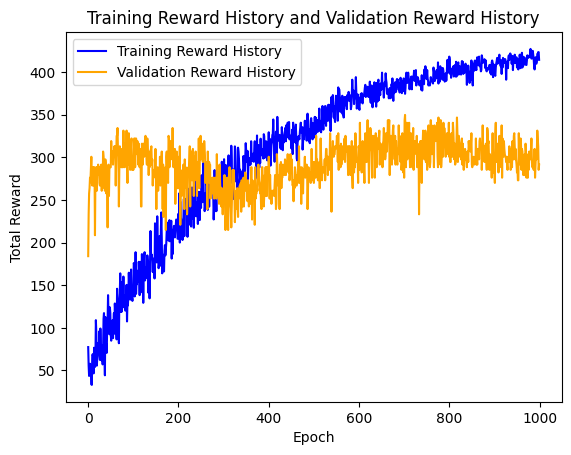

In [10]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

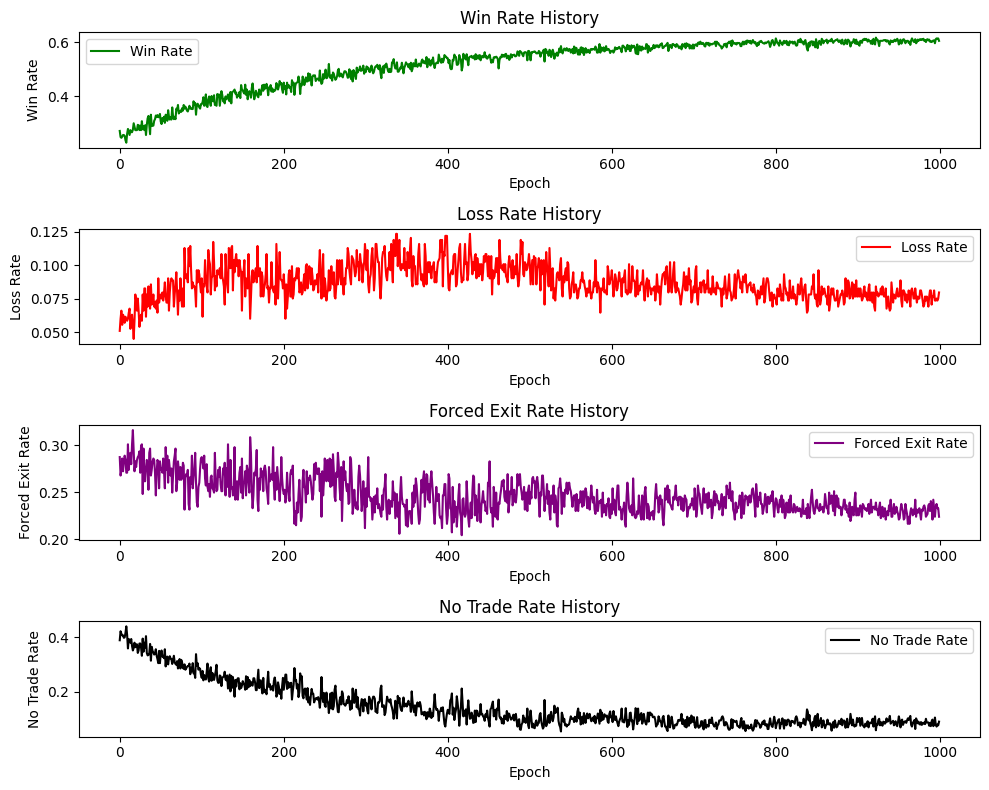

In [11]:
#Plot win rate, loss rate, forced exit rate, and no trade rate on separate subplots
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(win_rate_history, color = 'green', label = 'Win Rate')
plt.title('Win Rate History')
plt.xlabel('Epoch')
plt.ylabel('Win Rate')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(loss_rate_history, color = 'red', label = 'Loss Rate')
plt.title('Loss Rate History')
plt.xlabel('Epoch')
plt.ylabel('Loss Rate') 
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(forced_exit_rate_history, color = 'purple', label = 'Forced Exit Rate')
plt.title('Forced Exit Rate History')
plt.xlabel('Epoch')
plt.ylabel('Forced Exit Rate')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(no_trade_rate_history, color = 'black', label = 'No Trade Rate')
plt.title('No Trade Rate History')
plt.xlabel('Epoch')
plt.ylabel('No Trade Rate')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
#Print final reward, win rate, loss rate, forced exit rate, and no trade rate
print(f"Final Training Reward: {reward_history[-1]}")
print(f"Final Win Rate: {win_rate_history[-1]}")
print(f"Final Loss Rate: {loss_rate_history[-1]}")
print(f"Final Forced Exit Rate: {forced_exit_rate_history[-1]}")
print(f"Final No Trade Rate: {no_trade_rate_history[-1]}")

Final Training Reward: 414.2857142857143
Final Win Rate: 0.606015037593985
Final Loss Rate: 0.07969924812030076
Final Forced Exit Rate: 0.22406015037593985
Final No Trade Rate: 0.09022556390977443


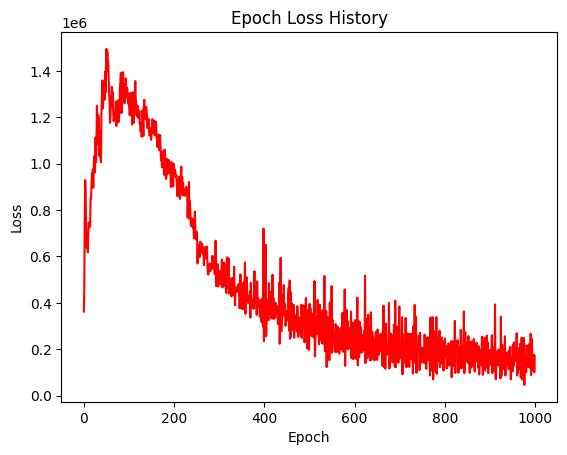

In [13]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Why the “sawtooth” spikes in the loss plot?

Those spikes are normal for two reasons:

    Variable number of updates per epoch: early on, you quickly fill the replay buffer and do many minibatch updates; later epochs may have fewer new transitions, so the average loss per epoch can jump around.

    Target-network syncs: whenever you copy the online net into the target net (every few epochs), you briefly raise the bootstrap targets, which can cause a transient bump in TD‐error before it falls again.

In [14]:
# smoothed = pd.Series(epoch_loss_history).rolling(10, min_periods=1).mean()
# plt.plot(smoothed, color = 'red')
# plt.title('Smoothed Epoch Loss History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

# Test agent 
---

In [15]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=F, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))


<All keys matched successfully>

* ## Check performance on training set (just to see if logic is correct)

In [16]:


# # test_rewards,trade_profits,actions,metrics = evaluate_dqn(
# #     online_net_trained,
# #     zscore_series_test,
# #     prices_test,
# #     beta_series_test,
# #     initial_capital,
# #     tx_cost,
# #     entry_stop_pairs,
# #     F, T
# # )
# # print(metrics)

# tx_cost = 0.0

# test_rewards,trade_profits,actions,episodes,metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
#     F, T
# )
# print(metrics)

* ## Check performance on test set 

In [36]:
#tx_cost = 0.0
tx_cost = 0.00025


test_rewards,trade_profits,cumulative_profit_series,actions,episodes,metrics = evaluate_dqn(
    online_net_trained,
    zscore_series_test,
    prices_test,
    beta_series_test,
    initial_capital,
    tx_cost,
    entry_stop_pairs,
    F, T
)
print(metrics)

{'avg_reward': np.float64(238.25503355704697), 'win_rate': 0.4966442953020134, 'loss_rate': 0.12751677852348994, 'forced_rate': 0.26174496644295303, 'no_trade_rate': 0.11409395973154363}


In [37]:
#Create a list of trade exit times from trade_profits
agent_trade_exit_times = []
for trade in trade_profits:
    if trade != 0:
        trade_exit_time = trade[0]
        agent_trade_exit_times.append(trade_exit_time)

#Create a list of the actual trade profits
agent_trade_profits = []
for trade in trade_profits:
    if trade != 0:
        trade_profit = trade[1]
        agent_trade_profits.append(trade_profit)

agent_trade_profits

[[np.float64(14.295310445236098)],
 [np.float64(-4.91797065477326)],
 [np.float64(13.040818764886806)],
 [np.float64(14.986649309912382)],
 [np.float64(-9.846558596910208)],
 [np.float64(-31.68607295336737)],
 [np.float64(5.803287280747511)],
 [np.float64(12.574004700689418)],
 [np.float64(23.854224385859762)],
 [np.float64(17.539680781250375)],
 [np.float64(-16.13879912175302)],
 [np.float64(10.97555527537273)],
 [np.float64(8.52427073872283)],
 [np.float64(9.557135691547769)],
 [np.float64(-24.53350119505106)],
 [np.float64(-37.99822663796425)],
 [np.float64(-18.607381195133705)],
 [np.float64(26.751926660563335)],
 [np.float64(6.670938377889065)],
 [np.float64(-4.277744910345557)],
 [np.float64(24.696278675306033)],
 [np.float64(146.32178830898505)],
 [np.float64(20.462033509957166)],
 [np.float64(-25.009849557841946)],
 [np.float64(23.501942248193906)],
 [np.float64(12.26558548437179)],
 [np.float64(14.754245904843346)],
 [np.float64(6.142031567289035)],
 [np.float64(-29.2493374505

In [38]:
trade_profits_cumulative_agent = np.cumsum(agent_trade_profits)
trade_profits_cumulative_agent = pd.Series(trade_profits_cumulative_agent, index=agent_trade_exit_times)
trade_profits_cumulative_agent

2024-06-03 10:05:00     14.295310
2024-06-03 18:00:00      9.377340
2024-06-03 19:35:00     22.418159
2024-06-04 03:55:00     37.404808
2024-06-04 11:05:00     27.558249
                          ...    
2024-06-29 01:20:00    255.403187
2024-06-29 05:50:00    249.347914
2024-06-29 07:20:00    256.852288
2024-06-29 18:10:00    265.127110
2024-06-29 19:35:00    268.344388
Length: 132, dtype: float64

In [39]:
# zipper = zip(test_rewards,trade_profits)
# for i, (reward, profit,) in enumerate(zipper):
#     print(f"Reward: {reward}, Trade Profit: {profit}")

Episode {'trade_start': Timestamp('2024-06-03 09:40:00'), 'trade_end': Timestamp('2024-06-03 13:45:00'), 'trade_entry_metadata': {'time': Timestamp('2024-06-03 09:45:00'), 'S1': np.float64(0.4698), 'S2': np.float64(0.4664), 'z': np.float64(0.6263320999992236), 'position': -1}, 'entry': 0.5, 'stop': 2.5}:


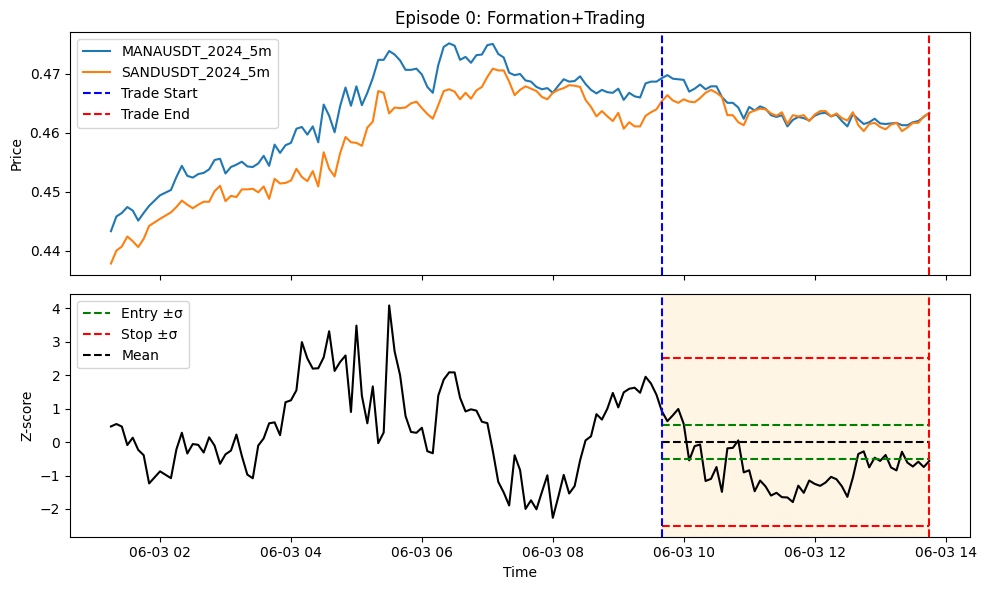

In [40]:
plot_episodes(prices_test, zscore_series_test, episodes, F, T, episode_idx=0)


Percentage_Return:  2.683443878887146 %


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_9407/4151984759.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (trade_profits_cumulative_agent[-1] / initial_capital) * 100,"%")


Text(0, 0.5, 'Cumulative Profit')

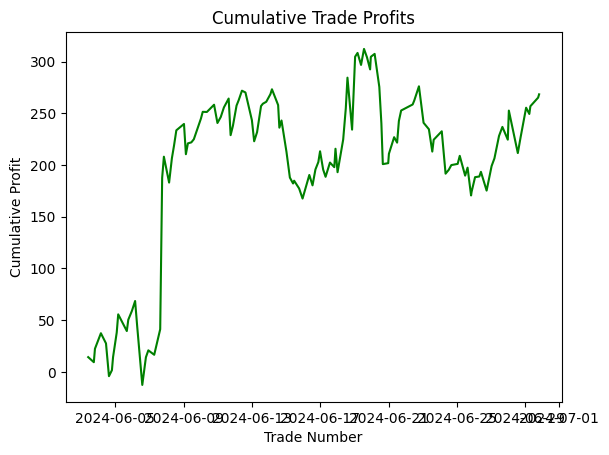

In [41]:
plt.plot(trade_profits_cumulative_agent, color = 'green')
print("Percentage_Return: ", (trade_profits_cumulative_agent[-1] / initial_capital) * 100,"%")
plt.title('Cumulative Trade Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')


In [43]:
#Ensure cumulative profit series cover the entire time period of the test set

trade_profits_cumulative_agent = trade_profits_cumulative_agent.reindex(prices_test.index, method='ffill').fillna(0)
trade_profits_cumulative_agent

timestamp
2024-06-03 01:15:00      0.000000
2024-06-03 01:20:00      0.000000
2024-06-03 01:25:00      0.000000
2024-06-03 01:30:00      0.000000
2024-06-03 01:35:00      0.000000
                          ...    
2024-06-29 23:20:00    268.344388
2024-06-29 23:35:00    268.344388
2024-06-29 23:40:00    268.344388
2024-06-29 23:45:00    268.344388
2024-06-29 23:55:00    268.344388
Length: 7556, dtype: float64

# Check performance with static thresholds
---

In [44]:
# # entry_threshold = 1.5
# # exit_threshold = 0
# # stop_loss_threshold = 3

# # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
# # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

# entry_threshold = 2
# exit_threshold = 0
# stop_loss_threshold = 4.5

# #WITH TRAINING SET
# #-----------------------

# # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
# # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

# #WITH TEST SET
# #-----------------------

# positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
# trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

In [45]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,0.4433,0.4378
2024-06-03 01:20:00,0.4458,0.4400
2024-06-03 01:25:00,0.4464,0.4407
2024-06-03 01:30:00,0.4474,0.4424
2024-06-03 01:35:00,0.4468,0.4416
...,...,...
2024-06-29 23:20:00,0.3312,0.3263
2024-06-29 23:35:00,0.3311,0.3261
2024-06-29 23:40:00,0.3307,0.3259


Percentage_Return:  -2.003686217716755 %


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_9407/1590744383.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


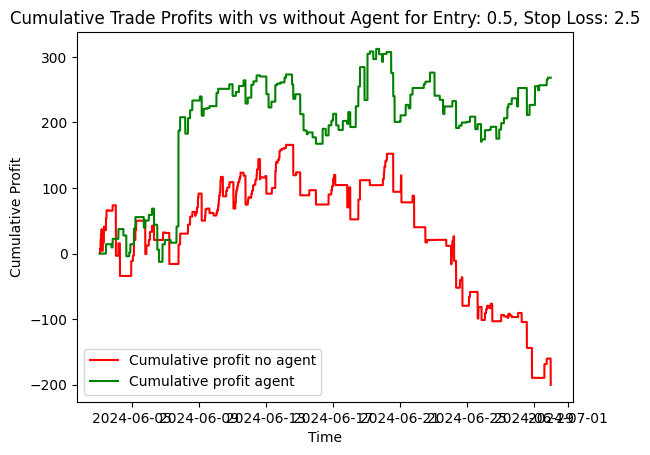

Percentage_Return:  2.1928788603453873 %


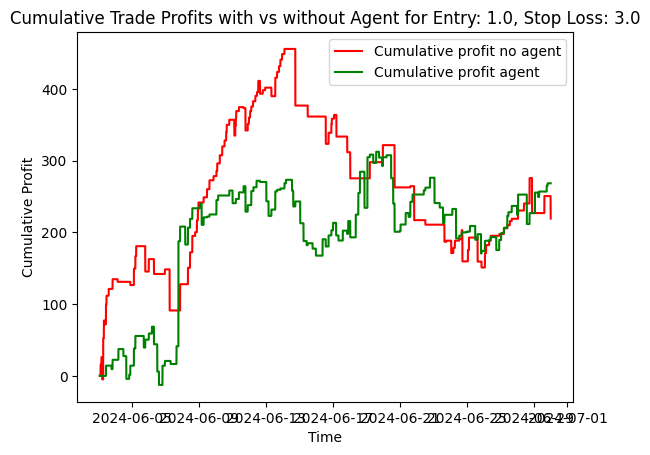

Percentage_Return:  2.8661041132655005 %


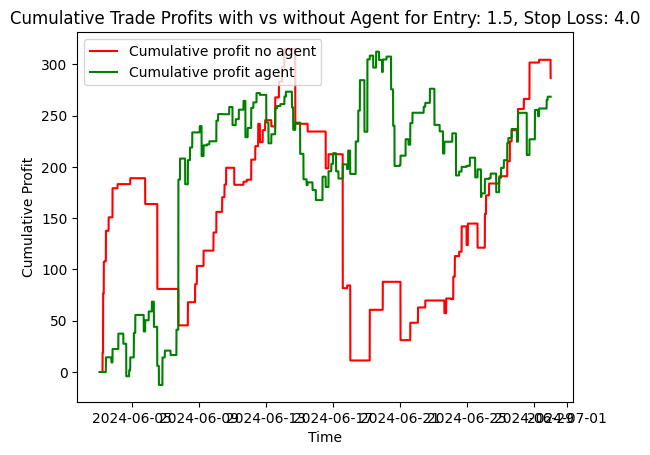

Percentage_Return:  1.6626977377026915 %


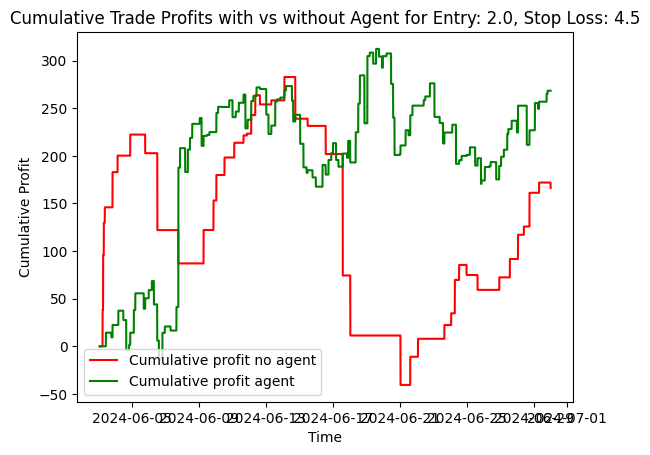

Percentage_Return:  2.406814202310896 %


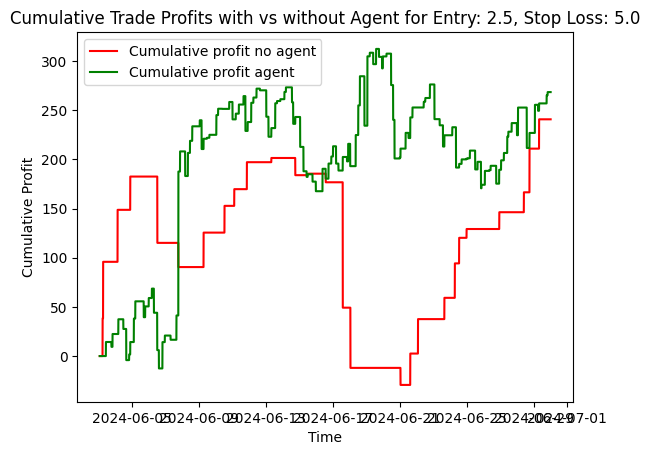

Percentage_Return:  -0.5121850736277322 %


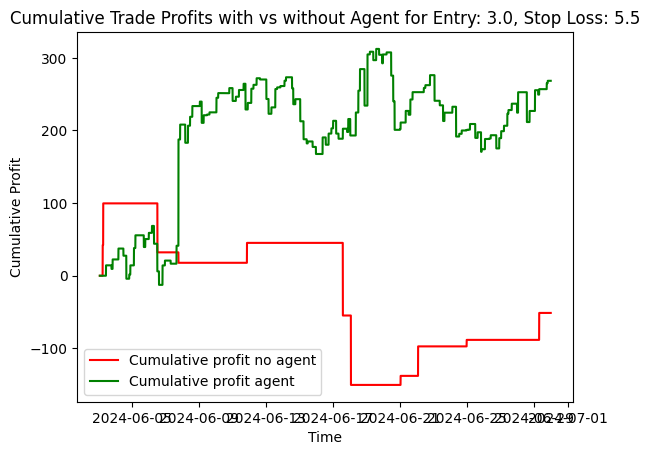

In [46]:
#Compare performance for all entry_stop_pairs 

entry_stop_pairs = [(0.5, 2.5), (1.0, 3.0), (1.5, 4.0), (2.0, 4.5), (2.5, 5.0), (3.0, 5.5)]
exit_threshold = 0
#tx_cost = 0.00025

for entry_stop_pair in entry_stop_pairs:
    entry_threshold, stop_loss_threshold = entry_stop_pair
    positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
    trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)
    cumulative_profit_series_no_agent_indexed = cumulative_profit_series_no_agent.reindex(prices_test.index, method='ffill').fillna(0)


    plt.plot(cumulative_profit_series_no_agent_indexed, color = 'red', label = 'Cumulative profit no agent') #Cumulative profits without agent
    plt.plot(trade_profits_cumulative_agent, color = 'green', label = 'Cumulative profit agent') #Cumulative profits with agent
    print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
    plt.title(f'Cumulative Trade Profits with vs without Agent for Entry: {entry_threshold}, Stop Loss: {stop_loss_threshold}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.show()